# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter. 

In [ ]:
# you will be prompted with a window asking to grant permissions
# from google.colab import drive
# drive.mount("/content/drive")

In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
# import os
# datadir = "/content/assignment3"
# if not os.path.exists(datadir):
#   !ln -s "/content/drive/My Drive/Your/Assignment3/path/" $datadir # TODO: Fill your Assignment 3 path
# os.chdir(datadir)
# !pwd

#Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__getitem__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import os

def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    # TODO: Implement rotate_img() - return the rotated img
    elif rot == 1:
        return transforms.functional.rotate(img, 90)
    elif rot == 2:
        return transforms.functional.rotate(img, 180)    
    elif rot == 3:
        return transforms.functional.rotate(img, 270)
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [9]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Show some example images and rotated images with labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


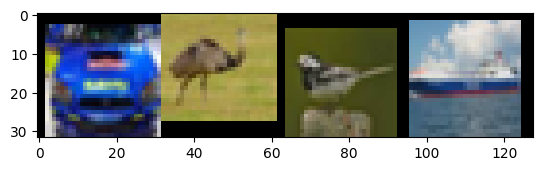

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class labels:  car   bird  bird  ship 


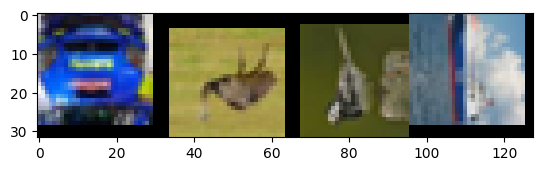

Rotation labels:  180   180   90    270  


In [10]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [102]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs = net(images)
            # print(outputs.shape, labels.shape)
            # outputs = torch.argmax(outputs, axis=1)
            total += len(images)
            # loss
            # print(outputs.shape, labels.shape)
            # print(labels[:10])
            # print(outputs[:10])
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
            predicted = torch.argmax(outputs, axis=1)
            correct += (predicted == labels).sum().item()
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [103]:
run_test(net, testloader, criterion, 'rotation')

TESTING:
Accuracy of the network on the 10000 test images: 56.20 %
Average loss on the 10000 test images: 1.023


In [43]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task

### In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [73]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

device

'mps'

In [74]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [75]:
import torch.optim as optim
criterion = None
optimizer = None

# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
#
optimizer = optim.Adam(net.parameters())
#

In [160]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):
    net = net.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels

            if task == 'rotation':
                data = imgs_rotated.to(device)
                labels = torch.eye(4)[rotation_label]
                labels = rotation_label.to(device)
            else:
                data = imgs.to(device)
                labels = torch.eye(10)[cls_label]
                labels = labels.to(device)

            # TODO: Zero the parameter gradients
            net.zero_grad()

            # TODO: forward + backward + optimize
            predicted = net(data)
            # print(predicted.shape, labels.shape)
            loss = criterion(predicted, labels)
            
            loss.backward()
            optimizer.step()
            
            # TODO: Get predicted results
            if task == 'rotation':
                predicted = torch.argmax(predicted, axis=1)
            else:
                predicted = torch.argmax(predicted, axis=1)
                labels = torch.argmax(labels, axis=1)
            
            # print(predicted.shape)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            # print(predicted.shape, labels.shape)
            # print(predicted[0], labels[0])
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        run_test(net, testloader, criterion, task)
        #

    print('Finished Training')

In [108]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

# TODO: Save the model
torch.save(net.state_dict(), "./model/rotation_trained.pt")

[1,   100] loss: 0.678 acc: 73.16 time: 7.69
[1,   200] loss: 0.693 acc: 72.62 time: 7.57
[1,   300] loss: 0.678 acc: 72.91 time: 7.46
TESTING:
Accuracy of the network on the 10000 test images: 74.01 %
Average loss on the 10000 test images: 0.650
[2,   100] loss: 0.672 acc: 73.87 time: 6.97
[2,   200] loss: 0.669 acc: 73.76 time: 6.93
[2,   300] loss: 0.665 acc: 73.68 time: 6.92
TESTING:
Accuracy of the network on the 10000 test images: 74.94 %
Average loss on the 10000 test images: 0.639
[3,   100] loss: 0.662 acc: 73.90 time: 6.92
[3,   200] loss: 0.656 acc: 74.11 time: 7.09
[3,   300] loss: 0.665 acc: 73.90 time: 6.96
TESTING:
Accuracy of the network on the 10000 test images: 73.47 %
Average loss on the 10000 test images: 0.665
[4,   100] loss: 0.653 acc: 74.45 time: 7.48
[4,   200] loss: 0.656 acc: 74.18 time: 7.50
[4,   300] loss: 0.638 acc: 75.00 time: 7.47
TESTING:
Accuracy of the network on the 10000 test images: 74.37 %
Average loss on the 10000 test images: 0.648
[5,   100] l

# Fine-tuning on the pre-trained model
### In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [127]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
net = resnet18(num_classes=4)
net.load_state_dict(torch.load("./model/rotation_trained.pt"))
#

<All keys matched successfully>

In [132]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
for name, module in net.named_children():
    if name == "layer4" or name == "fc":
        module.requires_grad_(True)
    else:
        module.requires_grad_(False)

# add another fc layer to turn 4 classes into 10 classes
net = nn.Sequential(
    net,
    nn.Linear(4, 10)
)

In [133]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 0.layer4.0.conv1.weight
	 0.layer4.0.bn1.weight
	 0.layer4.0.bn1.bias
	 0.layer4.0.conv2.weight
	 0.layer4.0.bn2.weight
	 0.layer4.0.bn2.bias
	 0.layer4.0.downsample.0.weight
	 0.layer4.0.downsample.1.weight
	 0.layer4.0.downsample.1.bias
	 0.layer4.1.conv1.weight
	 0.layer4.1.bn1.weight
	 0.layer4.1.bn1.bias
	 0.layer4.1.conv2.weight
	 0.layer4.1.bn2.weight
	 0.layer4.1.bn2.bias
	 0.fc.weight
	 0.fc.bias
	 1.weight
	 1.bias


In [134]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([x for x in net.parameters() if x.requires_grad])

In [162]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')


[1,   100] loss: 1.246 acc: 54.07 time: 4.90
[1,   200] loss: 1.252 acc: 54.77 time: 4.79
[1,   300] loss: 1.246 acc: 54.92 time: 4.86
TESTING:
Accuracy of the network on the 10000 test images: 55.88 %
Average loss on the 10000 test images: 1.215
[2,   100] loss: 1.253 acc: 54.34 time: 4.80
[2,   200] loss: 1.232 acc: 55.41 time: 5.02
[2,   300] loss: 1.251 acc: 54.82 time: 4.85
TESTING:
Accuracy of the network on the 10000 test images: 56.28 %
Average loss on the 10000 test images: 1.208
[3,   100] loss: 1.222 acc: 55.58 time: 4.87
[3,   200] loss: 1.220 acc: 55.73 time: 4.88
[3,   300] loss: 1.242 acc: 54.72 time: 4.86
TESTING:
Accuracy of the network on the 10000 test images: 56.62 %
Average loss on the 10000 test images: 1.198
[4,   100] loss: 1.222 acc: 55.67 time: 4.79
[4,   200] loss: 1.210 acc: 55.95 time: 5.04
[4,   300] loss: 1.221 acc: 55.24 time: 4.85
TESTING:
Accuracy of the network on the 10000 test images: 58.18 %
Average loss on the 10000 test images: 1.175
[5,   100] l

# Fine-tuning on the randomly initialized model
### In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [163]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
#
net = resnet18(num_classes=10)
#

In [164]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
for name, module in net.named_children():
    if name == "layer4" or name == "fc":
        module.requires_grad_(True)
    else:
        module.requires_grad_(False)

In [165]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [166]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([x for x in net.parameters() if x.requires_grad])

In [168]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.609 acc: 42.60 time: 4.93
[1,   200] loss: 1.643 acc: 40.52 time: 4.80
[1,   300] loss: 1.634 acc: 40.99 time: 4.81
TESTING:
Accuracy of the network on the 10000 test images: 44.18 %
Average loss on the 10000 test images: 1.570
[2,   100] loss: 1.635 acc: 41.41 time: 4.82
[2,   200] loss: 1.645 acc: 40.04 time: 4.83
[2,   300] loss: 1.642 acc: 41.08 time: 4.81
TESTING:
Accuracy of the network on the 10000 test images: 44.08 %
Average loss on the 10000 test images: 1.569
[3,   100] loss: 1.632 acc: 41.90 time: 4.81
[3,   200] loss: 1.631 acc: 41.55 time: 4.81
[3,   300] loss: 1.638 acc: 41.00 time: 4.87
TESTING:
Accuracy of the network on the 10000 test images: 43.47 %
Average loss on the 10000 test images: 1.578
[4,   100] loss: 1.630 acc: 41.81 time: 4.83
[4,   200] loss: 1.623 acc: 41.98 time: 4.82
[4,   300] loss: 1.640 acc: 41.48 time: 4.89
TESTING:
Accuracy of the network on the 10000 test images: 44.30 %
Average loss on the 10000 test images: 1.577
[5,   100] l

# Supervised training on the pre-trained model
### In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [169]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
#
net = resnet18(num_classes=4)
net.load_state_dict(torch.load("./model/rotation_trained.pt"))
#
# add another fc layer to turn 4 classes into 10 classes
net = nn.Sequential(
    net,
    nn.Linear(4, 10)
)

In [170]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [171]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.648 acc: 42.23 time: 7.01
[1,   200] loss: 1.198 acc: 57.19 time: 6.97
[1,   300] loss: 1.085 acc: 62.68 time: 6.96
TESTING:
Accuracy of the network on the 10000 test images: 67.74 %
Average loss on the 10000 test images: 0.953
[2,   100] loss: 0.966 acc: 67.63 time: 6.97
[2,   200] loss: 0.929 acc: 68.77 time: 6.97
[2,   300] loss: 0.866 acc: 70.41 time: 6.96
TESTING:
Accuracy of the network on the 10000 test images: 72.90 %
Average loss on the 10000 test images: 0.818
[3,   100] loss: 0.810 acc: 72.69 time: 6.99
[3,   200] loss: 0.806 acc: 72.39 time: 6.96
[3,   300] loss: 0.790 acc: 73.04 time: 6.97
TESTING:
Accuracy of the network on the 10000 test images: 72.97 %
Average loss on the 10000 test images: 0.816
[4,   100] loss: 0.744 acc: 74.82 time: 6.98
[4,   200] loss: 0.744 acc: 75.38 time: 6.99
[4,   300] loss: 0.728 acc: 75.60 time: 6.97
TESTING:
Accuracy of the network on the 10000 test images: 76.86 %
Average loss on the 10000 test images: 0.692
[5,   100] l

# Supervised training on the randomly initialized model
### In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [172]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
#
net = resnet18(num_classes=10)
#

In [173]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [174]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.301 acc: 21.59 time: 7.06
[1,   200] loss: 1.851 acc: 31.71 time: 7.00
[1,   300] loss: 1.701 acc: 36.55 time: 6.93
TESTING:
Accuracy of the network on the 10000 test images: 42.02 %
Average loss on the 10000 test images: 1.675
[2,   100] loss: 1.532 acc: 43.98 time: 6.96
[2,   200] loss: 1.473 acc: 46.04 time: 6.98
[2,   300] loss: 1.371 acc: 49.87 time: 7.01
TESTING:
Accuracy of the network on the 10000 test images: 53.78 %
Average loss on the 10000 test images: 1.283
[3,   100] loss: 1.273 acc: 53.73 time: 6.96
[3,   200] loss: 1.210 acc: 56.80 time: 7.02
[3,   300] loss: 1.177 acc: 57.80 time: 6.97
TESTING:
Accuracy of the network on the 10000 test images: 62.85 %
Average loss on the 10000 test images: 1.046
[4,   100] loss: 1.082 acc: 61.38 time: 7.03
[4,   200] loss: 1.063 acc: 62.01 time: 6.98
[4,   300] loss: 1.029 acc: 63.62 time: 6.97
TESTING:
Accuracy of the network on the 10000 test images: 64.80 %
Average loss on the 10000 test images: 1.007
[5,   100] l